# Flight Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

pd.set_option("display.max_columns", 500)
plt.style.use("seaborn-colorblind")
pal = sns.color_palette()
%load_ext lab_black

In [2]:
!ls -GFlash ./flights/flights/ | grep parquet

216M -rw-rw-r-- 1 robmulla 216M Oct  7 10:27 Combined_Flights_2018.parquet
295M -rw-rw-r-- 1 robmulla 295M Oct  7 10:42 Combined_Flights_2019.parquet
175M -rw-rw-r-- 1 robmulla 175M Oct  7 10:51 Combined_Flights_2020.parquet
232M -rw-rw-r-- 1 robmulla 232M Oct  7 11:00 Combined_Flights_2021.parquet
143M -rw-rw-r-- 1 robmulla 143M Oct  7 11:03 Combined_Flights_2022.parquet


In [3]:
!ls -GFlash ./flights/flights/ | grep csv

 40K -rw-rw-r-- 1 robmulla  39K Oct  7 10:44 Airlines.csv
1.9G -rw-rw-r-- 1 robmulla 1.9G Oct  7 10:27 Combined_Flights_2018.csv
2.7G -rw-rw-r-- 1 robmulla 2.7G Oct  7 10:42 Combined_Flights_2019.csv
1.7G -rw-rw-r-- 1 robmulla 1.7G Oct  7 10:51 Combined_Flights_2020.csv
2.1G -rw-rw-r-- 1 robmulla 2.1G Oct  7 11:00 Combined_Flights_2021.csv
1.4G -rw-rw-r-- 1 robmulla 1.4G Oct  7 11:03 Combined_Flights_2022.csv


# Read in and Format Data

In [4]:
parquet_files = glob("flights/flights/*.parquet")

In [5]:
column_subset = [
    "FlightDate",
    "Airline",
    "Flight_Number_Marketing_Airline",
    "Origin",
    "Dest",
    "Cancelled",
    "Diverted",
    "CRSDepTime",
    "DepTime",
    "DepDelayMinutes",
    "OriginAirportID",
    "OriginCityName",
    "OriginStateName",
    "DestAirportID",
    "DestCityName",
    "DestStateName",
    "TaxiOut",
    "TaxiIn",
    "CRSArrTime",
    "ArrTime",
    "ArrDelayMinutes",
]

dfs = []
for f in parquet_files:
    dfs.append(pd.read_parquet(f, columns=column_subset))
df = pd.concat(dfs).reset_index(drop=True)

cat_cols = ["Airline", "Origin", "Dest", "OriginStateName", "DestStateName"]
for c in cat_cols:
    df[c] = df[c].astype("category")

# Understand the `DepDelayMinutes` Variable

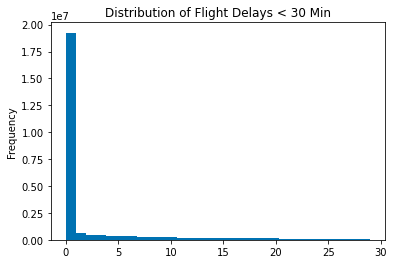

In [264]:
df.query("DepDelayMinutes < 30")["DepDelayMinutes"].plot(
    kind="hist", bins=30, title="Distribution of Flight Delays < 30 Min"
)
plt.show()

In [64]:
df.query("DepDelayMinutes != 0")["DepDelayMinutes"].value_counts()

1.0       586538
2.0       469218
3.0       412742
4.0       373030
5.0       342582
           ...  
3075.0         1
2532.0         1
1616.0         1
2814.0         1
1951.0         1
Name: DepDelayMinutes, Length: 1861, dtype: int64

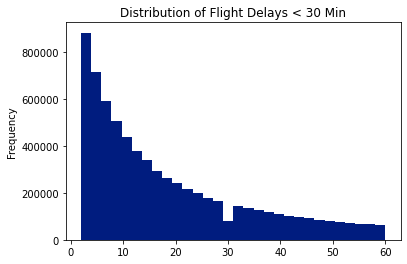

In [71]:
df.query("DepDelayMinutes > 1 and DepDelayMinutes < 61")["DepDelayMinutes"].plot(
    kind="hist", bins=30, title="Distribution of Flight Delays < 30 Min"
)
plt.show()

# Grouping of Delays
Per Wikipedia https://en.wikipedia.org/wiki/Flight_cancellation_and_delay:
```
Delays are divided into three categories, namely "on time or small delay" (up to 15 minutes delay), "Medium delay" (15 – 45 minutes delay) and "Large delay" ( 45 minutes delay). 
```

In [8]:
df["DelayGroup"] = None
df.loc[df["DepDelayMinutes"] == 0, "DelayGroup"] = "OnTime_Early"
df.loc[
    (df["DepDelayMinutes"] > 0) & (df["DepDelayMinutes"] <= 15), "DelayGroup"
] = "Small_Delay"
df.loc[
    (df["DepDelayMinutes"] > 15) & (df["DepDelayMinutes"] <= 45), "DelayGroup"
] = "Medium_Delay"
df.loc[df["DepDelayMinutes"] > 45, "DelayGroup"] = "Large_Delay"
df.loc[df["Cancelled"], "DelayGroup"] = "Cancelled"

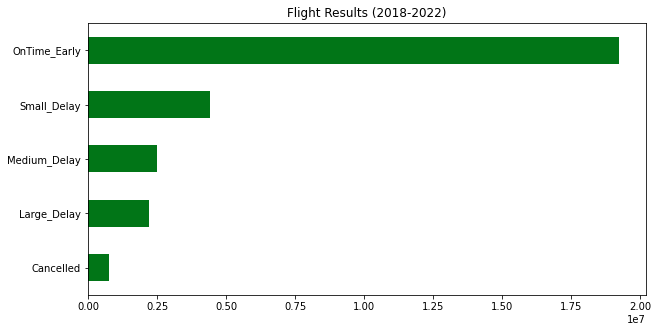

In [124]:
df["DelayGroup"].value_counts(ascending=True).plot(
    kind="barh", figsize=(10, 5), color=pal[1], title="Flight Results (2018-2022)"
)
plt.show()

# How Many Flights Per Year?

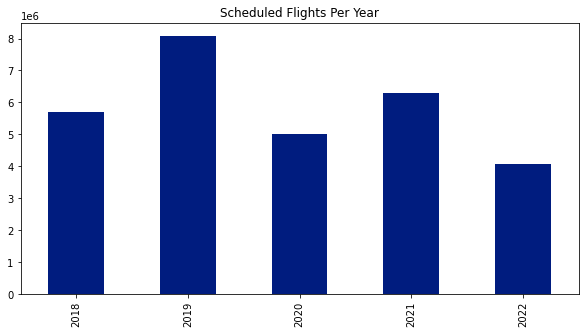

In [141]:
df["Year"].value_counts().sort_index().plot(
    kind="bar", figsize=(10, 5), title="Scheduled Flights Per Year"
)
plt.show()

<AxesSubplot:xlabel='Year', ylabel='count'>

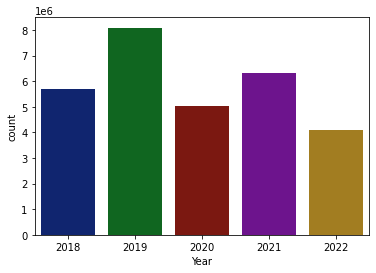

In [162]:
sns.countplot(x=df["Year"])

# What is the % of Flight Results by Year

In [174]:
df.groupby("Year")["DelayGroup"].value_counts(normalize=True).unstack()

DelayGroup,Cancelled,Large_Delay,Medium_Delay,OnTime_Early,Small_Delay
Year,,,,,
2018,0.015536,0.083178,0.095384,0.641156,0.164746
2019,0.018986,0.086832,0.090816,0.646198,0.157168
2020,0.059942,0.037277,0.045723,0.760523,0.096534
2021,0.017589,0.074798,0.089179,0.656981,0.161453
2022,0.030207,0.095453,0.109265,0.588012,0.177064


In [175]:
df["Year"] = df["FlightDate"].dt.year
df_agg = df.groupby("Year")["DelayGroup"].value_counts(normalize=True).unstack() * 100
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_agg[col_order].style.background_gradient(cmap="Greens")

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Year,,,,,
2018,64.115615,16.474583,9.538448,8.317789,1.553565
2019,64.619787,15.716778,9.081583,8.683248,1.898604
2020,76.052291,9.653418,4.572319,3.727722,5.994249
2021,65.698142,16.145308,8.917879,7.479795,1.758876
2022,58.801153,17.706368,10.926539,9.545283,3.020657


# Results by Month

In [176]:
df["Month"] = df["FlightDate"].dt.month
df_agg = df.groupby("Month")["DelayGroup"].value_counts(normalize=True).unstack() * 100
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_agg[col_order].style.background_gradient(cmap="Blues")

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Month,,,,,
1,68.169907,13.961832,7.878093,7.008976,2.981192
2,64.960611,15.300969,8.828322,7.786858,3.123240
3,66.363322,14.172305,7.716007,6.173113,5.575252
4,64.436275,14.051844,7.824258,6.853866,6.833756
5,65.023841,16.224252,8.965554,7.875154,1.911198
6,59.488265,17.349791,10.754222,10.442093,1.965629
7,61.996702,16.361900,10.052315,9.906083,1.683000
8,64.622096,15.009025,9.096512,9.137345,2.135022
9,72.924881,13.140776,6.725733,5.813787,1.394822


In [179]:
df["Month"] = df["FlightDate"].dt.month
df_agg = (
    df.query("Year != 2020")
    .groupby("Month")["DelayGroup"]
    .value_counts(normalize=True)
    .unstack()
    * 100
)
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_agg[col_order].style.background_gradient(cmap="Blues")

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Month,,,,,
1,67.162457,13.880797,8.068641,7.353867,3.534239
2,62.623134,15.912800,9.424684,8.139587,3.899795
3,65.869000,16.332230,8.904784,7.101697,1.792290
4,66.161402,15.715543,8.783821,7.685515,1.653719
5,63.468665,17.070321,9.537899,8.407955,1.515159
6,56.855480,18.188167,11.525967,11.298683,2.131703
7,58.511717,17.645319,11.048691,10.968325,1.825949
8,60.348823,16.490201,10.289753,10.508081,2.363141
9,70.637088,14.016242,7.374660,6.454308,1.517702


## Why High Cancellation in March/April? What does it look like by year for these months?

In [204]:
df["Month"] = df["FlightDate"].dt.month
df_agg = (
    df.query("3 <= Month <= 4")
    .groupby("Year")["DelayGroup"]
    .value_counts(normalize=True)
    .unstack()
    * 100
)
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]
df_agg[col_order].style.background_gradient(cmap="Oranges", axis=0)

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Year,,,,,
2018,64.219260,17.194531,9.582907,7.347652,1.655651
2019,65.790141,15.462990,8.614418,7.974924,2.157527
2020,63.063286,6.202543,3.291875,2.733237,24.709059
2021,76.291254,13.015721,5.715776,4.077733,0.899516
2022,59.301505,18.234213,11.096981,9.445164,1.922137


# Plot using `calmap`

In [181]:
import calmap

Text(0.5, 0.92, 'US Flight Cancellations')

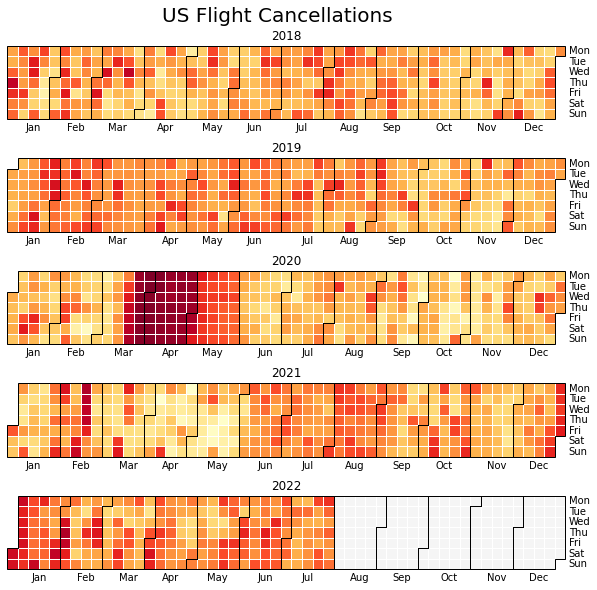

In [234]:
events = df.groupby("FlightDate")["Cancelled"].mean()
fig, axs = plt.subplots(5, 1, figsize=(10, 10))
for i, year in enumerate([2018, 2019, 2020, 2021, 2022]):
    calmap.yearplot(
        events.apply(np.log), year=year, cmap="YlOrRd", monthly_border=True, ax=axs[i]
    )
    axs[i].set_title(year)
fig.suptitle("US Flight Cancellations", y=0.92, fontsize=20)

In [160]:
df["Year"] = df["FlightDate"].dt.year

In [161]:
df.groupby("Year")["Cancelled"].sum()

Year
2018     88373
2019    153629
2020    301055
2021    111018
2022    123192
Name: Cancelled, dtype: int64

,FlightDate,Airline,Flight_Number_Marketing_Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,OriginAirportID,OriginCityName,OriginStateName,DestAirportID,DestCityName,DestStateName,TaxiOut,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,DelayGroup,Year
0,2020-09-01,Comair Inc.,5020,PHL,DAY,False,False,1905,1858.0,0.0,14100,"Philadelphia, PA",Pennsylvania,11267,"Dayton, OH",Ohio,16.0,4.0,2056,2034.0,0.0,OnTime_Early,2020
1,2020-09-02,Comair Inc.,5020,PHL,DAY,False,False,1905,1858.0,0.0,14100,"Philadelphia, PA",Pennsylvania,11267,"Dayton, OH",Ohio,16.0,5.0,2056,2027.0,0.0,OnTime_Early,2020
2,2020-09-03,Comair Inc.,5020,PHL,DAY,False,False,1905,1855.0,0.0,14100,"Philadelphia, PA",Pennsylvania,11267,"Dayton, OH",Ohio,65.0,5.0,2056,2122.0,26.0,OnTime_Early,2020
3,2020-09-04,Comair Inc.,5020,PHL,DAY,False,False,1905,1857.0,0.0,14100,"Philadelphia, PA",Pennsylvania,11267,"Dayton, OH",Ohio,13.0,4.0,2056,2027.0,0.0,OnTime_Early,2020
4,2020-09-05,Comair Inc.,5020,PHL,DAY,False,False,1905,1856.0,0.0,14100,"Philadelphia, PA",Pennsylvania,11267,"Dayton, OH",Ohio,14.0,4.0,2056,2026.0,0.0,OnTime_Early,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29193777,2022-03-31,Republic Airlines,3621,MSY,EWR,False,True,1949,2014.0,25.0,13495,"New Orleans, LA",Louisiana,11618,"Newark, NJ",New Jersey,17.0,32.0,2354,234.0,NaN,Medium_Delay,2022
29193778,2022-03-17,Republic Airlines,3437,CLT,EWR,True,False,1733,1817.0,44.0,11057,"Charlotte, NC",North Carolina,11618,"Newark, NJ",New Jersey,NaN,NaN,1942,NaN,NaN,Cancelled,2022
29193779,2022-03-08,Republic Airlines,3413,ALB,ORD,False,False,1700,2318.0,378.0,10257,"Albany, NY",New York,13930,"Chicago, IL",Illinois,19.0,7.0,1838,59.0,381.0,Large_Delay,2022
29193780,2022-03-25,Republic Airlines,3450,EWR,PIT,False,True,2129,2322.0,113.0,11618,"Newark, NJ",New Jersey,14122,"Pittsburgh, PA",Pennsylvania,25.0,6.0,2255,939.0,NaN,Large_Delay,2022


In [87]:
events.max()

11808

In [102]:
"""
Calendar heatmaps from Pandas time series data.

Plot Pandas time series data sampled by day in a heatmap per calendar year,
similar to GitHub's contributions calendar.
"""


from __future__ import unicode_literals

import calendar
import datetime

from matplotlib.colors import ColorConverter, ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from distutils.version import StrictVersion
from dateutil.relativedelta import relativedelta
from matplotlib.patches import Polygon

__version_info__ = ("0", "0", "9")
__date__ = "22 Nov 2018"


__version__ = ".".join(__version_info__)
__author__ = "Marvin Thielk; Martijn Vermaat"
__contact__ = "marvin.thielk@gmail.com, martijn@vermaat.name"
__homepage__ = "https://github.com/MarvinT/calmap"

_pandas_18 = StrictVersion(pd.__version__) >= StrictVersion("0.18")


def yearplot(
    data,
    year=None,
    how="sum",
    vmin=None,
    vmax=None,
    cmap="Reds",
    fillcolor="whitesmoke",
    linewidth=1,
    linecolor=None,
    daylabels=calendar.day_abbr[:],
    dayticks=True,
    monthlabels=calendar.month_abbr[1:],
    monthticks=True,
    monthly_border=False,
    ax=None,
    **kwargs
):
    """
    Plot one year from a timeseries as a calendar heatmap.

    Parameters
    ----------
    data : Series
        Data for the plot. Must be indexed by a DatetimeIndex.
    year : integer
        Only data indexed by this year will be plotted. If `None`, the first
        year for which there is data will be plotted.
    how : string
        Method for resampling data by day. If `None`, assume data is already
        sampled by day and don't resample. Otherwise, this is passed to Pandas
        `Series.resample`.
    vmin : float
        Min Values to anchor the colormap. If `None`, min and max are used after
        resampling data by day.
    vmax : float
        Max Values to anchor the colormap. If `None`, min and max are used after
        resampling data by day.
    cmap : matplotlib colormap name or object
        The mapping from data values to color space.
    fillcolor : matplotlib color
        Color to use for days without data.
    linewidth : float
        Width of the lines that will divide each day.
    linecolor : color
        Color of the lines that will divide each day. If `None`, the axes
        background color is used, or 'white' if it is transparent.
    daylabels : list
        Strings to use as labels for days, must be of length 7.
    dayticks : list or int or bool
        If `True`, label all days. If `False`, don't label days. If a list,
        only label days with these indices. If an integer, label every n day.
    monthlabels : list
        Strings to use as labels for months, must be of length 12.
    monthticks : list or int or bool
        If `True`, label all months. If `False`, don't label months. If a
        list, only label months with these indices. If an integer, label every
        n month.
    monthly_border : bool
        Draw black border for each month. Default: False.
    ax : matplotlib Axes
        Axes in which to draw the plot, otherwise use the currently-active
        Axes.
    kwargs : other keyword arguments
        All other keyword arguments are passed to matplotlib `ax.pcolormesh`.

    Returns
    -------
    ax : matplotlib Axes
        Axes object with the calendar heatmap.

    Examples
    --------

    By default, `yearplot` plots the first year and sums the values per day:

    .. plot::
        :context: close-figs

        calmap.yearplot(events)

    We can choose which year is plotted with the `year` keyword argment:

    .. plot::
        :context: close-figs

        calmap.yearplot(events, year=2015)

    The appearance can be changed by using another colormap. Here we also use
    a darker fill color for days without data and remove the lines:

    .. plot::
        :context: close-figs

        calmap.yearplot(events, cmap='YlGn', fillcolor='grey',
                        linewidth=0)

    The axis tick labels can look a bit crowded. We can ask to draw only every
    nth label, or explicitely supply the label indices. The labels themselves
    can also be customized:

    .. plot::
        :context: close-figs

        calmap.yearplot(events, monthticks=3, daylabels='MTWTFSS',
                        dayticks=[0, 2, 4, 6])

    """
    if year is None:
        year = data.index.sort_values()[0].year

    if how is None:
        # Assume already sampled by day.
        by_day = data
    else:
        # Sample by day.
        if _pandas_18:
            by_day = data.resample("D").agg(how)
        else:
            by_day = data.resample("D", how=how)

    # Min and max per day.
    # if vmin is None:
    # vmin = by_day.min()
    # if vmax is None:
    # vmax = by_day.max()

    if ax is None:
        ax = plt.gca()

    if linecolor is None:
        # Unfortunately, linecolor cannot be transparent, as it is drawn on
        # top of the heatmap cells. Therefore it is only possible to mimic
        # transparent lines by setting them to the axes background color. This
        # of course won't work when the axes itself has a transparent
        # background so in that case we default to white which will usually be
        # the figure or canvas background color.
        linecolor = ax.get_facecolor()
        if ColorConverter().to_rgba(linecolor)[-1] == 0:
            linecolor = "white"

    # Filter on year.
    by_day = by_day[str(year)]

    # Add missing days.
    by_day = by_day.reindex(
        pd.date_range(start=str(year), end=str(year + 1), freq="D")[:-1]
    )

    # Create data frame we can pivot later.
    by_day = pd.DataFrame(
        {
            "data": by_day,
            "fill": 1,
            "day": by_day.index.dayofweek,
            "week": by_day.index.isocalendar().week,
        }
    )

    # There may be some days assigned to previous year's last week or
    # next year's first week. We create new week numbers for them so
    # the ordering stays intact and week/day pairs unique.
    by_day.loc[(by_day.index.month == 1) & (by_day.week > 50), "week"] = 0
    by_day.loc[(by_day.index.month == 12) & (by_day.week < 10), "week"] = (
        by_day.week.max() + 1
    )

    # Pivot data on day and week and mask NaN days. (we can also mask the days with 0 counts)
    plot_data = by_day.pivot("day", "week", "data").values[::-1]
    plot_data = np.ma.masked_where(np.isnan(plot_data), plot_data)

    # Do the same for all days of the year, not just those we have data for.
    fill_data = by_day.pivot("day", "week", "fill").values[::-1]
    fill_data = np.ma.masked_where(np.isnan(fill_data), fill_data)

    # Draw background of heatmap for all days of the year with fillcolor.
    ax.pcolormesh(fill_data, vmin=0, vmax=1, cmap=ListedColormap([fillcolor]))

    # Draw heatmap.
    kwargs["linewidth"] = linewidth
    kwargs["edgecolors"] = linecolor
    ax.pcolormesh(plot_data, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)

    # Limit heatmap to our data.
    ax.set(xlim=(0, plot_data.shape[1]), ylim=(0, plot_data.shape[0]))

    # Square cells.
    ax.set_aspect("equal")

    # Remove spines and ticks.
    for side in ("top", "right", "left", "bottom"):
        ax.spines[side].set_visible(False)
    ax.xaxis.set_tick_params(which="both", length=0)
    ax.yaxis.set_tick_params(which="both", length=0)

    # Get indices for monthlabels.
    if monthticks is True:
        monthticks = range(len(monthlabels))
    elif monthticks is False:
        monthticks = []
    elif isinstance(monthticks, int):
        monthticks = range(len(monthlabels))[monthticks // 2 :: monthticks]

    # Get indices for daylabels.
    if dayticks is True:
        dayticks = range(len(daylabels))
    elif dayticks is False:
        dayticks = []
    elif isinstance(dayticks, int):
        dayticks = range(len(daylabels))[dayticks // 2 :: dayticks]

    ax.set_xlabel("")
    timestamps = []

    # Month borders
    xticks, labels = [], []
    for month in range(1, 13):
        first = datetime.datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)
        # Monday on top
        y0 = 6 - first.weekday()
        y1 = 6 - last.weekday()
        start = datetime.datetime(year, 1, 1).weekday()
        x0 = (int(first.strftime("%j")) + start - 1) // 7
        x1 = (int(last.strftime("%j")) + start - 1) // 7
        P = [
            (x0, y0 + 1),
            (x0, 0),
            (x1, 0),
            (x1, y1),
            (x1 + 1, y1),
            (x1 + 1, 7),
            (x0 + 1, 7),
            (x0 + 1, y0 + 1),
        ]

        xticks.append(x0 + (x1 - x0 + 1) / 2)
        labels.append(first.strftime("%b"))
        if monthly_border:
            poly = Polygon(
                P,
                edgecolor="black",
                facecolor="None",
                linewidth=1,
                zorder=20,
                clip_on=False,
            )
            ax.add_artist(poly)

    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_ylabel("")
    ax.yaxis.set_ticks_position("right")
    ax.set_yticks([6 - i + 0.5 for i in dayticks])
    ax.set_yticklabels(
        [daylabels[i] for i in dayticks], rotation="horizontal", va="center"
    )

    return ax


def calendarplot(
    data,
    how="sum",
    yearlabels=True,
    yearascending=True,
    yearlabel_kws=None,
    subplot_kws=None,
    gridspec_kws=None,
    fig_kws=None,
    fig_suptitle=None,
    vmin=None,
    vmax=None,
    **kwargs
):
    """
    Plot a timeseries as a calendar heatmap.

    Parameters
    ----------
    data : Series
        Data for the plot. Must be indexed by a DatetimeIndex.
    how : string
        Method for resampling data by day. If `None`, assume data is already
        sampled by day and don't resample. Otherwise, this is passed to Pandas
        `Series.resample`.
    yearlabels : bool
       Whether or not to draw the year for each subplot.
    yearascending : bool
       Sort the calendar in ascending or descending order.
    yearlabel_kws : dict
       Keyword arguments passed to the matplotlib `set_ylabel` call which is
       used to draw the year for each subplot.
    subplot_kws : dict
        Keyword arguments passed to the matplotlib `add_subplot` call used to
        create each subplot.
    gridspec_kws : dict
        Keyword arguments passed to the matplotlib `GridSpec` constructor used
        to create the grid the subplots are placed on.
    fig_kws : dict
        Keyword arguments passed to the matplotlib `figure` call.
    fig_suptitle : string
        Title for the entire figure..
    vmin : float
        Min Values to anchor the colormap. If `None`, min and max are used after
        resampling data by day.
    vmax : float
        Max Values to anchor the colormap. If `None`, min and max are used after
        resampling data by day.
    kwargs : other keyword arguments
        All other keyword arguments are passed to `yearplot`.

    Returns
    -------
    fig, axes : matplotlib Figure and Axes
        Tuple where `fig` is the matplotlib Figure object `axes` is an array
        of matplotlib Axes objects with the calendar heatmaps, one per year.

    Examples
    --------

    With `calendarplot` we can plot several years in one figure:

    .. plot::
        :context: close-figs

        calmap.calendarplot(events)

    """
    yearlabel_kws = yearlabel_kws or {}
    subplot_kws = subplot_kws or {}
    gridspec_kws = gridspec_kws or {}
    fig_kws = fig_kws or {}

    years = np.unique(data.index.year)
    if not yearascending:
        years = years[::-1]

    fig, axes = plt.subplots(
        nrows=len(years),
        ncols=1,
        squeeze=False,
        subplot_kw=subplot_kws,
        gridspec_kw=gridspec_kws,
        **fig_kws
    )
    axes = axes.T[0]
    plt.suptitle(fig_suptitle)
    # We explicitely resample by day only once. This is an optimization.
    if how is None:
        by_day = data
    else:
        if _pandas_18:
            by_day = data.resample("D").agg(how)
        else:
            by_day = data.resample("D", how=how)

    ylabel_kws = dict(
        fontsize=32,
        color=kwargs.get("fillcolor", "whitesmoke"),
        fontweight="bold",
        fontname="Arial",
        ha="center",
    )
    ylabel_kws.update(yearlabel_kws)

    max_weeks = 0

    for year, ax in zip(years, axes):
        yearplot(by_day, year=year, how=None, ax=ax, **kwargs)
        max_weeks = max(max_weeks, ax.get_xlim()[1])

        if yearlabels:
            ax.set_ylabel(str(year), **ylabel_kws)

    # In a leap year it might happen that we have 54 weeks (e.g., 2012).
    # Here we make sure the width is consistent over all years.
    for ax in axes:
        ax.set_xlim(0, max_weeks)

    # Make the axes look good.
    plt.tight_layout()

    return fig, axes

In [104]:
events.max()

11808

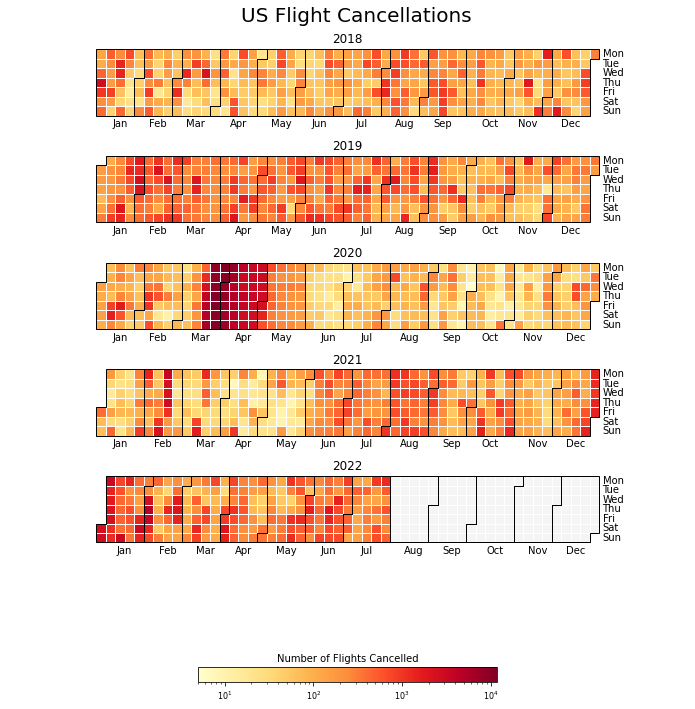

In [155]:
import calmap
import matplotlib.colors as colors

events = df.groupby("FlightDate")["Cancelled"].sum()

fig, axs = plt.subplots(
    6, 1, figsize=(10, 10), gridspec_kw={"height_ratios": [2, 2, 2, 2, 2, 3]}
)
for i, year in enumerate([2018, 2019, 2020, 2021, 2022]):
    cax = yearplot(
        events,
        vmin=None,
        vmax=None,
        year=year,
        norm=colors.LogNorm(vmin=events.min(), vmax=events.max()),
        cmap="YlOrRd",
        monthly_border=True,
        ax=axs[i],
    )
    axs[i].set_title(year)
fig.patch.set_facecolor("white")

clb = fig.colorbar(cax.get_children()[1], ax=axs[-1], orientation="horizontal")

clb.ax.tick_params(labelsize=8)
clb.ax.set_title("Number of Flights Cancelled", fontsize=10)
axs[-1].axis("off")
fig.suptitle("US Flight Cancellations", y=0.98, fontsize=20)
plt.tight_layout()
fig.savefig("temp.png", facecolor=fig.get_facecolor(), edgecolor="none", dpi=500)
plt.show()

In [168]:
df.groupby(["Year"])["Airline"].value_counts().unstack()

,Air Wisconsin Airlines Corp,Alaska Airlines Inc.,Allegiant Air,American Airlines Inc.,Cape Air,Capital Cargo International,Comair Inc.,"Commutair Aka Champlain Enterprises, Inc.",Compass Airlines,Delta Air Lines Inc.,Empire Airlines Inc.,Endeavor Air Inc.,Envoy Air,ExpressJet Airlines Inc.,Frontier Airlines Inc.,"GoJet Airlines, LLC d/b/a United Express",Hawaiian Airlines Inc.,Horizon Air,JetBlue Airways,Mesa Airlines Inc.,Peninsula Airways Inc.,Republic Airlines,SkyWest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,Trans States Airlines,United Air Lines Inc.,Virgin America
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018,98763,184751,96221,385183,1661,44440,117132,48010,44898,461718,9087,120030,127750,167180,120035,63498,83723,85245,305010,153697,1309,203529,531792,1352552,176178,66885,621565,17670
2019,106894,264817,105305,946776,0,123054,288989,58052,94209,991986,8833,257246,327084,134277,135543,79063,83891,121897,297411,227831,1474,329596,836755,1363946,204845,76000,625910,0
2020,53989,138226,98489,569806,0,72359,192613,32953,15878,581101,5090,211457,211435,52212,91175,38989,40414,96063,144163,135927,0,219772,596986,961276,135102,18705,308217,0
2021,80256,188955,115881,736399,0,99331,222602,76666,0,747998,112,266867,255751,0,137142,60143,60542,111628,202702,159789,0,332926,753343,1064640,191361,0,446837,0
2022,40300,129510,73504,495953,0,52827,135884,44367,0,512114,0,142624,150758,0,86557,34793,42212,56320,156793,71972,0,197881,440807,731925,129208,0,352009,0


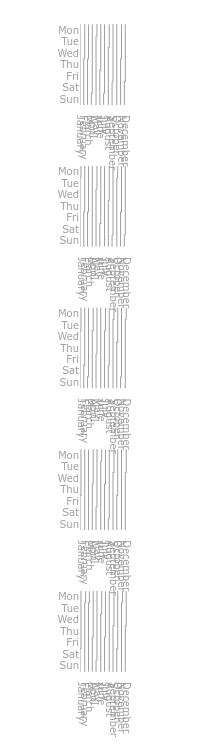

In [243]:
from plotly_calplot import calplot

# creating the plot
fig = calplot(events.apply(np.log).reset_index(), x="FlightDate", y="Cancelled")
fig.show()

# Compare Airlines
- Who has the most delays?
- Who has the most cancellations?
- Who is the most reliable? (on time)

Text(0.5, 0, 'Flights (100k)')

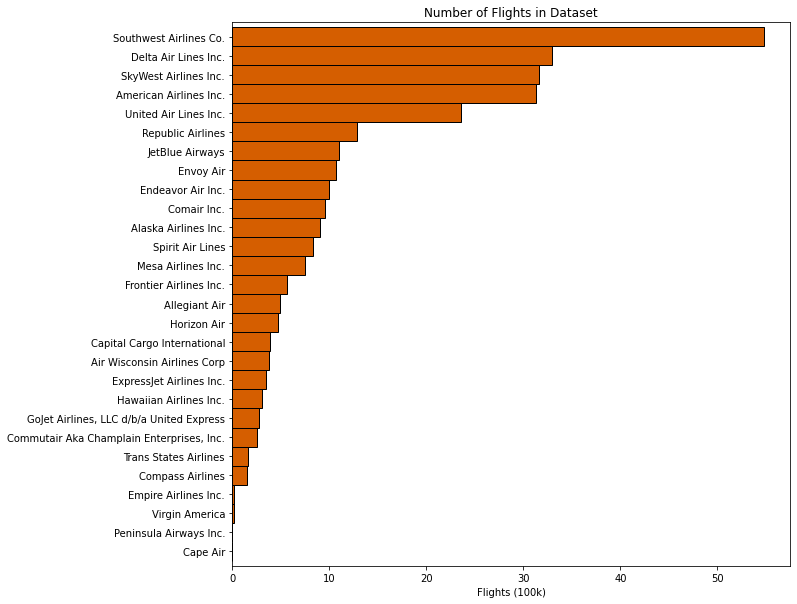

In [287]:
fig, ax = plt.subplots(figsize=(10, 10))
airlines_ordered = (df["Airline"].value_counts(ascending=True) / 100_000).plot(
    kind="barh", ax=ax, color=pal[2], width=1, edgecolor="black"
)
ax.set_title("Number of Flights in Dataset")
ax.set_xlabel("Flights (100k)")

## Subset to the Top Airlines
- Minimum 1M Flights

In [9]:
top_airlines = (
    df["Airline"]
    .value_counts()
    .reset_index()
    .query("Airline > 1_000_000")["index"]
    .values.tolist()
)

df_top = df.loc[df["Airline"].isin(top_airlines)].reset_index(drop=True).copy()

In [18]:
df_top["Airline"] = df_top["Airline"].astype("str").astype("category")

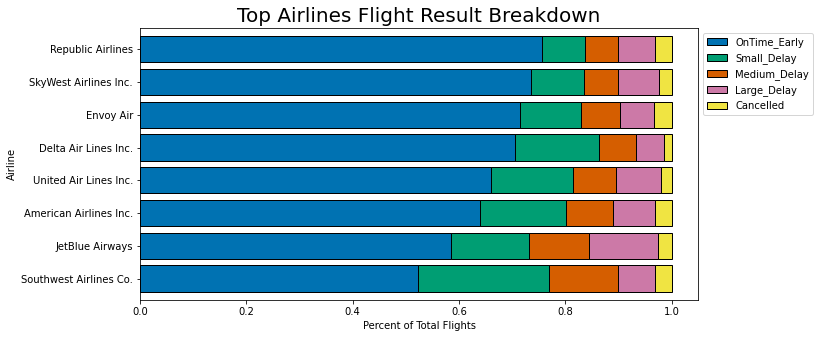

In [64]:
col_order = ["OnTime_Early", "Small_Delay", "Medium_Delay", "Large_Delay", "Cancelled"]

df_agg = (
    df_top.groupby(["Airline"])["DelayGroup"]
    .value_counts(normalize=True)
    .unstack()[col_order]
)

fig, ax = plt.subplots(figsize=(10, 5))
df_agg.sort_values("OnTime_Early").plot(
    kind="barh", stacked=True, ax=ax, width=0.8, edgecolor="black"
)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title("Top Airlines Flight Result Breakdown", fontsize=20)
ax.set_xlabel("Percent of Total Flights")
plt.show()

## Split out Each Delay Type and plot

In [66]:
delay_mapping = {
    "OnTime_Early": "Good",
    "Small_Delay": "Good",
    "Medium_Delay": "Bad",
    "Large_Delay": "Bad",
    "Cancelled": "Bad",
}

In [67]:
df_top["DelayOk"] = df_top["DelayGroup"].map(delay_mapping)

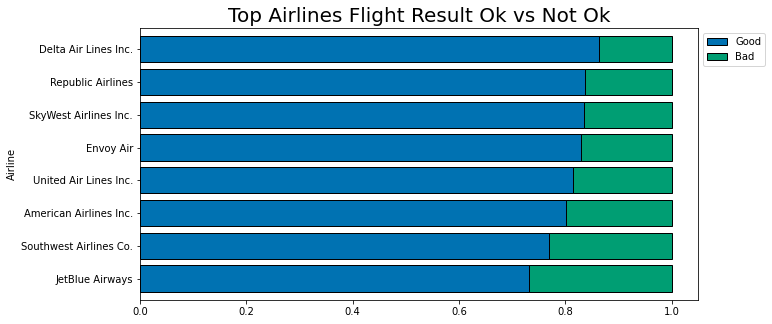

In [69]:
df_agg = (
    df_top.groupby(["Airline"])["DelayOk"]
    .value_counts(normalize=True)
    .unstack()[["Good", "Bad"]]
)

fig, ax = plt.subplots(figsize=(10, 5))
df_agg.sort_values("Good").plot(
    kind="barh", stacked=True, ax=ax, width=0.8, edgecolor="black"
)
ax.legend(bbox_to_anchor=(1, 1))
ax.set_title("Top Airlines Flight Result Ok vs Not Ok", fontsize=20)

plt.show()